In this script is the data smoothen after the PC are constructed 

In [1]:
# importing tools 
import s3fs
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt 
import math
#for removing warnings
import warnings

In [18]:
def open_s3fs(path):
    # open the data with s3fs from the databucket 
    fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
    data_path = f's3://data/{path}/*'
    remote_files = fsg.glob(data_path)
    fileset = [fsg.open(file) for file in remote_files]
    #open the dataset 
    dset = xr.open_mfdataset(fileset, combine='by_coords',compat='override')
    # rename variabel
    dset = dset.rename({'__xarray_dataarray_variable__' : 'vel'})
    return dset

In [3]:
dset = open_s3fs('PC-data')
dset

<xarray.Dataset>
Dimensions:        (depth: 75, x: 1580, y: 1801)
Coordinates:
  * depth          (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    time_centered  object ...
    time_counter   object ...
    nav_lat        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
Dimensions without coordinates: x, y
Data variables:
    vel            (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    mbathy         (y, x) int16 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    vomecrty       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    vozocrtx       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>

In [4]:
# open the data with s3fs from the databucket 
fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
data_path1 = 's3://velocity-u.zarr/'
data_path2 = 's3://velocity-v.zarr/'
remote_files1 = fsg.glob(data_path1)
remote_files2 = fsg.glob(data_path2)

store1 = s3fs.S3Map(root=data_path1, s3=fsg, check=False)
store2 = s3fs.S3Map(root=data_path2, s3=fsg, check=False)
du = xr.open_zarr(store=store1, consolidated=True)
du = du.rename({'depthu' : 'depth'})
dv = xr.open_zarr(store=store2, consolidated=True)
dv = dv.rename({'depthv' : 'depth'})

In [5]:
# Smoothen data, over every tenth point in both x and y direction, for all the data
vvar = dset.vomecrty.isel(y=slice(900,1800), x=slice(200,1400))
uvar = dset.vozocrtx.isel(y=slice(900,1800), x=slice(200,1400))
uv = dset.vel.isel(y=slice(900,1800), x=slice(200,1400))

# Getting the bottom level  
d = dset.mbathy.isel(y=slice(900,1800), x=slice(200,1400))

# Getting the velocity 
u = du.vozocrtx.isel(y=slice(900,1800), x=slice(200,1400))
v = dv.vomecrty.isel(y=slice(900,1800), x=slice(200,1400))
vel = np.sqrt(u**2 + v**2)

In [7]:
punkt_list = [(500,500), (650,300), (870,600), (820,200), (520,350)]

500 500
650 300
870 600
820 200
520 350


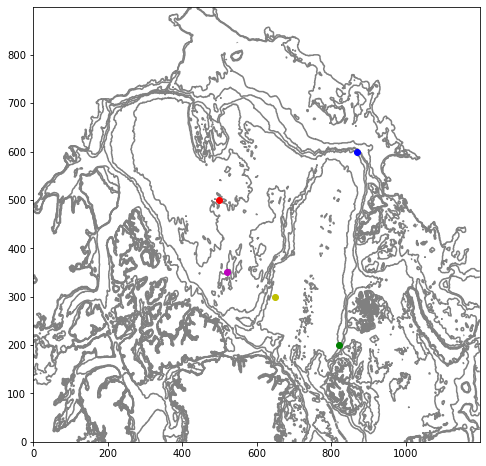

In [8]:
fig, axs = plt.subplots(1,1,figsize=(8,8))
c_list = ['r', 'y', 'b', 'g', 'm']
axs.contour(d, colors = 'grey')

for p in range(len((punkt_list))):
    
    pp = punkt_list[p]
    print(pp[0], pp[1]) 
    axs.plot(pp[0],pp[1] ,marker = 'o' ,color = c_list[p])

# for one point first 

In [9]:
# chosing a point 
pp = punkt_list[3]
x=pp[0]
y=pp[1]

# chosing the last level with velocity 
d_p = d.isel(x=x,y=y).values
print(d_p)
u_p = u.isel(x=x,y=y,depth=d_p-1)
v_p = v.isel(x=x,y=y,depth=d_p-1)
vel_p = np.sqrt(u_p**2 + v_p**2)
vel_p.shape

59


(73,)

In [10]:
vel_p.values

KeyboardInterrupt: 

In [11]:
u

<xarray.DataArray 'vozocrtx' (time_counter: 73, depth: 75, y: 900, x: 1200)>
dask.array<getitem, shape=(73, 75, 900, 1200), dtype=float32, chunksize=(1, 75, 900, 1200), chunktype=numpy.ndarray>
Coordinates:
  * depth          (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    nav_lat        (y, x) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
    time_centered  (time_counter) object dask.array<chunksize=(73,), meta=np.ndarray>
  * time_counter   (time_counter) object 2000-01-03 12:00:00 ... 2000-12-29 1...
Dimensions without coordinates: y, x
Attributes:
    cell_methods:        time: mean (interval: 360 s)
    interval_operation:  360 s
    interval_write:      5 d
    long_name:           sea_water_x_velocity
    online_operation:    average
    standard_name:       sea_water_x_velocity
    units:               m/s

In [20]:
# Fetching the major and minor of the bottom current
cov_p = np.cov(vel_p.T, bias=True)

values_p, vectors_p = np.linalg.eig(cov_p)
order = values_p.argsort()[::-1]
values_p, vectors_p = values_p[order], vectors_p[:, order]

#
major = vectors_p[:,0]
minor = vectors_p[:,1]

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

In [ ]:
print(vel.shape)
print(major.shape)
print(minor.shape)

In [ ]:
# Projecting the original vel data onto minor and major for all depths and timesteps



# For alle punkter

In [6]:
# List of x,y elements
dx = 20
dy = 20

scale = 2e3

jmax, imax = uv_b.shape
i_list = np.arange(0,imax,dx)
j_list = np.arange(0,jmax,dy)

# Making the covmatrix and finding the eigenvalues and eigenvectors
# ----------------------------------------------------------------------
y = []
x = []

#ellipser:
theta_l = np.zeros((900,1200,73))
minor_l = np.zeros((900,1200,73,2))
major_l = np.zeros((900,1200,73,2))
indx = 0

# to get the loop to run faster
uvy = np.array(uv_b.y.values)
uvx = np.array(uv_b.x.values)


uvarb = np.array(uvar_b.values)
vvarb = np.array(vvar_b.values)
uvb = np.array(uv_b.values)

for i in i_list:
    for j in j_list:
        d_p = d.isel(x=i, y=j)
        dyp = vel.isel(depth=slice(0,d_p-1))
        covm = np.cov(dyp.T, bias=True)
        if np.isnan(covm).any():
            continue
        else:
            # Find and sort eigenvalues and eigenvectors into descending order
                values, vectors = np.linalg.eig(covm)
                order = values.argsort()[::-1]
                values, vectors = values[order], vectors[:, order]

                # center of ellipse
                y.append(uvy[j])
                x.append(uvx[i])

                # ellipser :
                major = np.sqrt(values[0])*scale
                minor = np.sqrt(values[1])*scale

                major_l.append(major)
                minor_l.append(minor)
                #major_info.append(values[0])

                # The anti-clockwise angle to rotate our ellipse by 
                vx, vy = vectors[:,0][0], vectors[:,0][1]
                theta = np.arctan2(vy, vx)*(180/math.pi)
                theta_l.append(theta)

                indx = indx + 1

# converting to np.arrays
y = np.array(y,dtype=float)
x = np.array(x,dtype=float)